purpose: reimplement OpenBox method and extend it for CNN

In [116]:
from torch import nn
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from torchvision import datasets, transforms, utils
from src.utility import convert_image_np
import tqdm
from collections import defaultdict
from torch.utils.data.sampler import SubsetRandomSampler
from matplotlib import gridspec
from lib.data import Mimic2
from lib.utility import show_tensor_image, show_acc, to_var
from lib.model import MLP
from lib.openbox import open_box, count_config, find_x
import copy
import matplotlib 

In [2]:
def train(net, trainloader, criterion, optimizer, print_every=None, epochs=1000, max_time=10):
    net.train()
    start = time.time()
    
    # max_time given in seconds
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, (x, y) in enumerate(trainloader):
            
            end = time.time()
            if end - start >= max_time:
                print('Finished Training in %ds' % (end-start))                
                return
            
            # get the inputs
            x, y = to_var(x), to_var(y)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data.item()
            if print_every is not None and i % print_every == (print_every-1): 
                print('[%d, %5d] loss: %.10f' %
                      (epoch + 1, i + 1, running_loss / print_every))
                running_loss = 0.0

    print('Finished Training in %ds' % (end-start))

# fully connected network with ReLu activation

In [3]:
net = MLP(neuron_sizes=[784, 8, 2, 2])
net

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=8, out_features=2, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=2, out_features=2, bias=True)
  )
)

In [4]:
def abs_diff(a, b):
    return torch.abs(a - b).sum().data.numpy()

def diff_check(net, num_runs=100):
    diff = []
    d = net.classifier[0].in_features
    for i in range(num_runs):
        x = to_var(torch.randn(d))
        W, b, C = open_box(net, x)
        diff.append(abs_diff(torch.mv(W, x) + b, net(x)))
    return diff

diff = diff_check(MLP([100,50,30,20,10]))
sns.distplot(diff, kde=False)
print('checking if it is exact')
print('min: %f, mean: %f, max: %f' % (np.min(diff), np.mean(diff), np.max(diff)))

checking if it is exact
min: 0.000000, mean: 0.000000, max: 0.000000


Processing...
Done!
MLP(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)


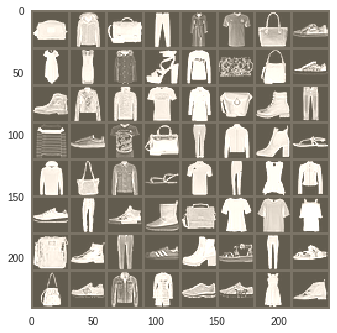

[1,   400] loss: 0.6030513236
[1,   800] loss: 0.4742875551
[2,   400] loss: 0.4401704074
[2,   800] loss: 0.4444274410
[3,   400] loss: 0.4319371926
Finished Training in 50s


In [5]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('fmnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('fmnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=False)

net = MLP(neuron_sizes=[784, 10])
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-4)

x, y = next(iter(train_loader))
show_tensor_image(x)

train(net, train_loader, criterion, optimizer, print_every=400, epochs=10, max_time=50)

In [6]:
show_acc(net, test_loader)

Accuracy of the network on 10000  images: 82 %


In [7]:
def getAvgImg(loader, criteria=lambda x: True):
    res = 0
    count = 0
    for x, y in loader:
        for i, im in enumerate(x):
            if criteria(y[i]):
                count += 1
                res += im
    return (res / count).numpy().reshape(28,28)

avg_images = []
for i in tqdm.tqdm(range(10)):
    im = getAvgImg(train_loader, criteria=lambda y: y == i)
    avg_images.append(im)

100%|██████████| 10/10 [01:21<00:00,  8.10s/it]


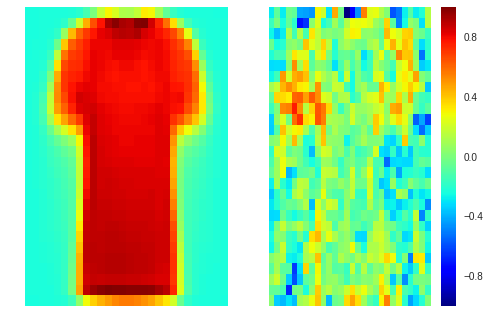

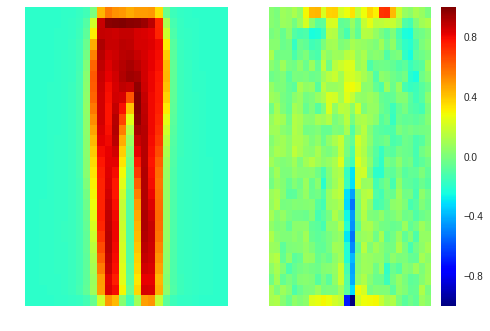

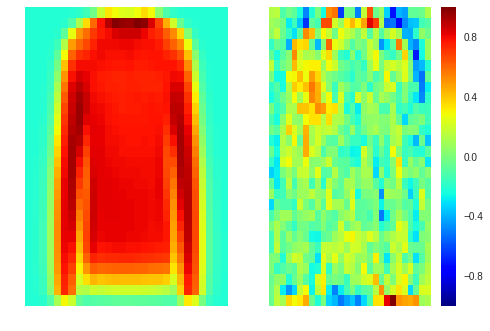

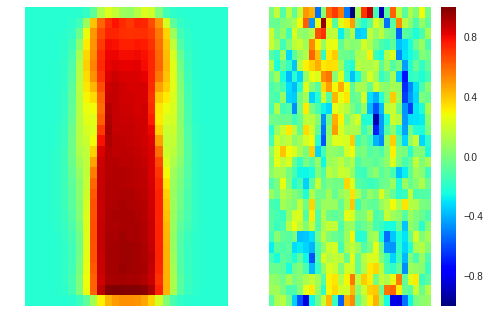

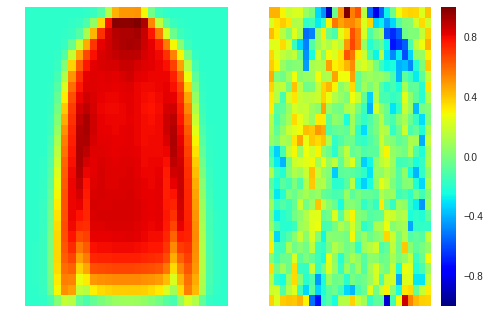

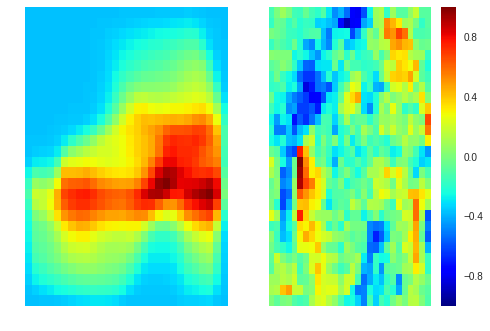

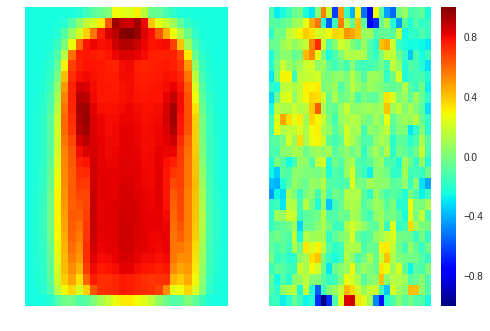

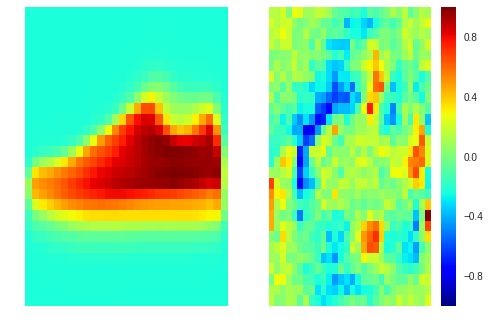

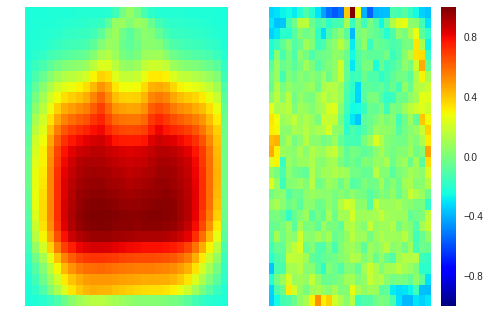

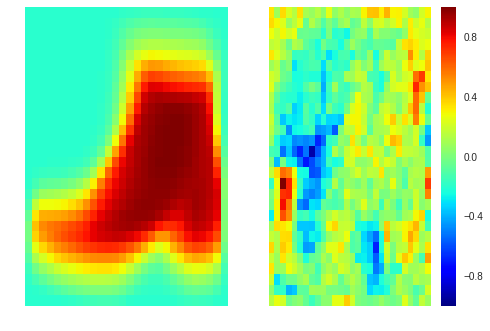

In [8]:
# visualization
def scale_figure(im): # scale activation to -1 to 1
    im = im / np.abs(im).max()
    return im

W, b, C = open_box(net, x[0].view(784))
for i in range(10):
    plt.subplot(121)
    im = scale_figure(avg_images[i])
    sns.heatmap(im, cbar=False, cmap='jet', vmin=-1, vmax=1)
    plt.gca().axis('off')
    
    plt.subplot(122)
    w = W[i] - W.mean(0)
    im = scale_figure(w.data.numpy().reshape(28,28))
    sns.heatmap(im, cmap='jet', vmin=-1, vmax=1)
    plt.gca().axis('off')

    plt.show()



# Fashion MNIST Binary Case (Paper Replication)

Lesson learned: multiple class explanation is hard to learn (could be one of future direction), first focus on binary cases

60000it [00:11, 5332.74it/s]
10000it [00:02, 4828.88it/s]


tensor([0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1])


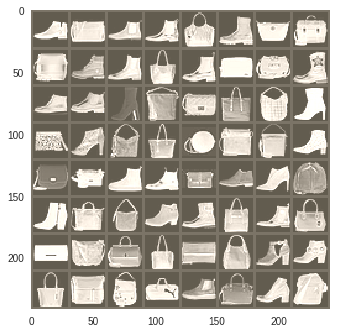

In [9]:
batch_size = 64

classes = [9, 8]

class SelectClasses():
    
    def __init__(self, classes):
        # remap classes labels
        self.classes = classes
    
    def __call__(self, y):
        num_classes = len(self.classes)
        try:
            return self.classes.index(y)
        except:
            return num_classes

train_data = datasets.FashionMNIST('fmnist_data', train=True, download=True,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))
                      ]),
                      target_transform=SelectClasses(classes)
                     )
test_data = datasets.FashionMNIST('fmnist_data', train=False, 
                     transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.1307,), (0.3081,))
                     ]),
                     target_transform=SelectClasses(classes)
                    )

train_subset = []
for i, (x, y) in tqdm.tqdm(enumerate(train_data)):
    if y < len(classes):
        train_subset.append(i)

test_subset = []
for i, (x, y) in tqdm.tqdm(enumerate(test_data)):
    if y < len(classes):
        test_subset.append(i)        
        
train_loader = torch.utils.data.DataLoader(train_data,
    batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(train_subset))

test_loader = torch.utils.data.DataLoader(test_data,
    batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(test_subset))

x, y = next(iter(train_loader))
print(y)
show_tensor_image(x)

In [10]:
fmnist1 = MLP(neuron_sizes=[784, 8, 2, 2])

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fmnist1.parameters(), weight_decay=1e-4)
train(fmnist1, train_loader, criterion, optimizer, print_every=100, epochs=10, max_time=50)

[1,   100] loss: 0.3486398926
[2,   100] loss: 0.1069075423
[3,   100] loss: 0.0169672716
[4,   100] loss: 0.0097787212
[5,   100] loss: 0.0069814162
[6,   100] loss: 0.0057724133
[7,   100] loss: 0.0046802769
[8,   100] loss: 0.0036467481
[9,   100] loss: 0.0029921939
[10,   100] loss: 0.0025339478
Finished Training in 43s


In [11]:
show_acc(fmnist1, test_loader)

Accuracy of the network on 2000  images: 99 %


In [12]:
config_counter_fmnist1 = count_config(fmnist1, train_loader)

100%|██████████| 188/188 [00:38<00:00,  4.84it/s]


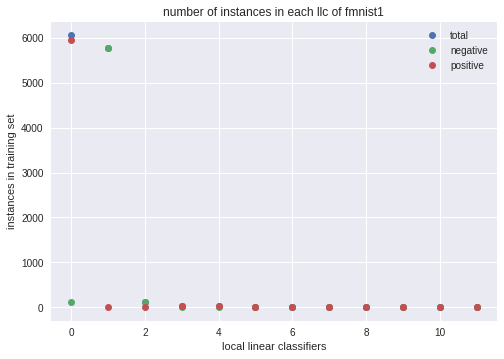

In [21]:
sorted_fmnist1_configs = sorted(map(lambda x: (x[0], sum(x[1].values()), x[1][0], x[1][1]), 
                                    config_counter_fmnist1.items()), 
                                key=lambda x: x[1], reverse=True)

plt.plot(list(map(lambda x: x[1], sorted_fmnist1_configs)), 'o', label='total')
plt.plot(list(map(lambda x: x[2], sorted_fmnist1_configs)), 'o', label='negative')
plt.plot(list(map(lambda x: x[3], sorted_fmnist1_configs)), 'o', label='positive')

plt.title('number of instances in each llc of fmnist1')
plt.xlabel('local linear classifiers')
plt.ylabel('instances in training set')
plt.legend()
plt.show()

config 1111111110 has 6056 instances (5950 positive, 106 negative) ranks 0


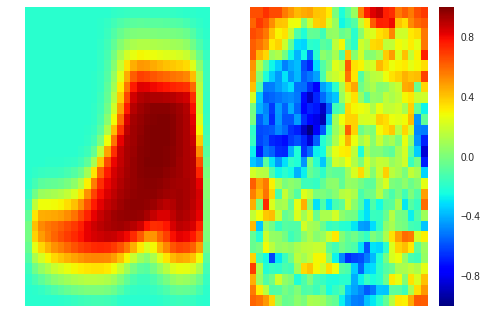

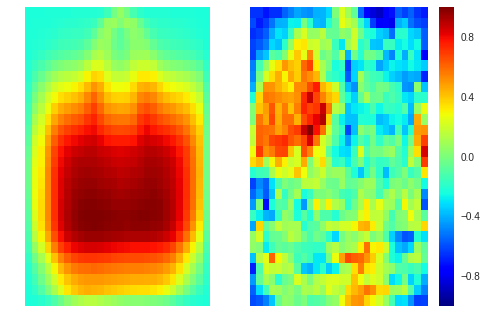

In [18]:
top = 0
print('config %s has %d instances (%d positive, %d negative) ranks %d' % (sorted_fmnist1_configs[top][0], 
                                                                          sorted_fmnist1_configs[top][1], 
                                                                          sorted_fmnist1_configs[top][3],
                                                                          sorted_fmnist1_configs[top][2],
                                                                          top))
x = find_x(sorted_fmnist1_configs[top][0], fmnist1, train_loader)

W, b, C = open_box(fmnist1, x.view(784))
gs = gridspec.GridSpec(1, 2, width_ratios=[5, 6])

for i in range(2):
    plt.subplot(gs[0])
    im = scale_figure(avg_images[classes[i]])
    sns.heatmap(im, cbar=False, cmap='jet', vmin=-1, vmax=1)
    plt.gca().axis('off')
    
    plt.subplot(gs[1])
    j = 0 if i==1 else 1
    w = W[i] - W[j]
    im = scale_figure(w.data.numpy().reshape(28,28))
    cax = sns.heatmap(im, cmap='jet', vmin=-1, vmax=1, cbar=True)
    plt.gca().axis('off')
    
    plt.show()

In [23]:
len(sorted_fmnist1_configs), 2**10

(12, 1024)

# see the effect of deepLIFT

In [ ]:
def instance_difference(net, x1, x2):
    pass

# change the prediction by changing top pixels

for each input, change a few pixels to see Change of Prediction Probability and Number of Label Changes

In [142]:
def hack_exp(net, loader, hack_num=50):
    net.eval()
    softmax = torch.nn.Softmax(1)
    CPP = []
    NLC = 0
    for xs, ys in loader:
        for i in range(len(xs)):
            x, y = xs[i], ys[i]
            W, b, C = open_box(net, x.view(28 * 28))
            explanation = W[1] - W[0]
            original_yhat = net(x)
            # hack the features with highest magnitude (for positive case: remove large positive features)
            if softmax(original_yhat)[0, 1].item() > 0.5:              
                _, sorted_indices = torch.sort(explanation)
            else:
                _, sorted_indices = torch.sort(-explanation)
            x_hacked = copy.deepcopy(x).reshape(-1)
            if hack_num > 0:
                x_hacked[sorted_indices[-hack_num:]] = 0
            hacked_yhat = net(x_hacked)
            # calculate the difference in change of probability
            CPP.append(softmax(original_yhat)[0, 1].item() - softmax(hacked_yhat)[0, 1].item())
            if torch.argmax(original_yhat) != torch.argmax(hacked_yhat):
                NLC += 1
    return CPP, NLC

CPPs, NLCs = [], []
hack_nums = [10, 100, 300, 600, 1000, 1500]
for hack_num in tqdm.tqdm(hack_nums):
    CPP, NLC = hack_exp(fmnist1, test_loader, hack_num)
    CPPs.append(np.mean(np.abs(CPP)))
    NLCs.append(NLC)

100%|██████████| 6/6 [00:24<00:00,  4.16s/it]


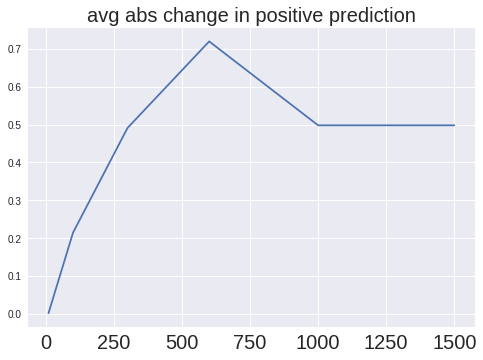

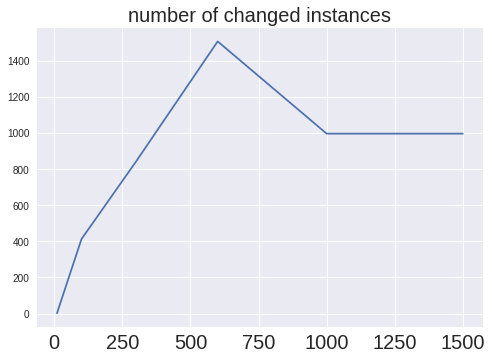

In [144]:
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=10) 

plt.plot(hack_nums, CPPs)
plt.title('avg abs change in positive prediction', fontsize=20)
plt.show()

plt.plot(hack_nums, NLCs)
plt.title('number of changed instances', fontsize=20)
plt.show()

0.498066541492 2000 997


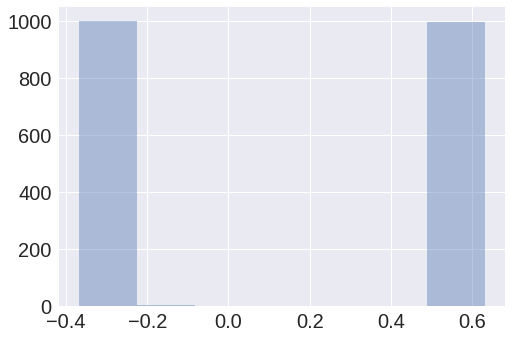

In [118]:
sns.distplot(CPP, kde=False)
print(np.mean(np.abs(CPP)), len(CPP), NLC)
plt.show()

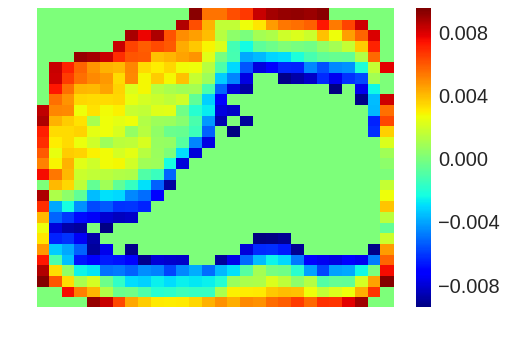

In [129]:
explanation = W[1]-W[0]
hack_num = 300
_, sorted_indices = torch.sort(torch.abs(explanation))
to_plot = to_var(copy.deepcopy(explanation.data))
if hack_num > 0:
    to_plot[sorted_indices[-hack_num:]] = 0

sns.heatmap(to_plot.reshape(28,28).data, cmap='jet')
plt.grid('off')
plt.axis('off')
plt.show()

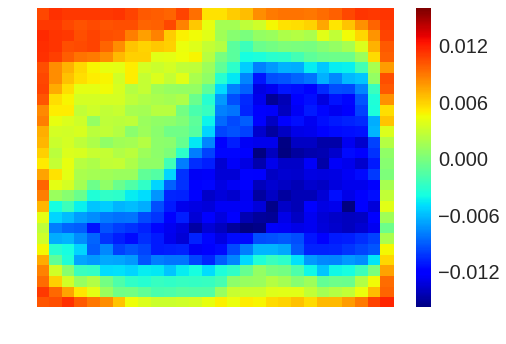

In [130]:
sns.heatmap(explanation.reshape(28,28).data, cmap='jet')
plt.grid('off')
plt.axis('off')
plt.show()

# total variation penalty on spatial data

1. Measure total variation of current prediction
2. use total variation as a penalty 
3. use l2 as penalty (this should fail b/c correaltion structure breaks down)
4. find out if hacking becomes harder

In [141]:
pic_exp = explanation.reshape(28,28)

def total_variation(pic, beta=2):
    assert len(pic.shape) == 2, 'assume image input'
    # pad left right
    pad_pic = torch.cat([pic, pic[:,-1].unsqueeze(1)], 1) # hstack
    lr = pad_pic[:,1:] - pad_pic[:,:-1]
    # pad up down
    pad_pic = torch.cat([pic, pic[-1,:].unsqueeze(0)], 0) # vstack
    ud = pad_pic[1:,:] - pad_pic[:-1,:]

    total = lr**2 + ud**2
    return torch.sum(total**(beta/2))

total_variation(pic_exp)

torch.Size([28, 28])


tensor(0.0090, grad_fn=<SumBackward0>)

In [136]:
pic_exp.shape

torch.Size([28, 28])